# Ejercicio 18

(primera parte)

a. Utilice Linear Discriminant Analysis (LDA)para reproducir las Figuras 4.7 y 4.8 del texto guia.

b. Utilizando los datos de Default construya una curva de precision-recall con los resultados del modelo regresión logística (http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). Escriba su propia función. No utilice la de sklearn

c. Utilizando el siguiente dataset

https://vincentarelbundock.github.io/Rdatasets/doc/MASS/Boston.html https://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv

encuentre los mejores predictores para saber si un suburbio tiene una rata de crimen mayor o menor a la media. Utilice LDA y regresion logistica junto a curvas ROC y Precision-Recall para justificar su respuesta.

(segunda parte)

d. Utilizando el siguiente dataset

https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Auto.html https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Auto.csv

repita los mismos pasos del punto c. para predecir si un carro tiene mpg mayor o menor a la media.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import scipy.integrate
import sklearn.discriminant_analysis
import itertools

# Primera parte

In [2]:
#Load data and define X, Y
data = pd.read_csv('Default.csv')
Y = data['default']
X = data[['balance']]

In [3]:
# Initialize fitting method, fit and predict
f = sklearn.linear_model.LogisticRegression()

# Split in train and test
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.5)

#  Fit with train
f.fit(X_train, Y_train)

# Predict with test
predict = f.predict(X_test)

# This is the probability for Default='Yes'
proba_yes = f.predict_proba(X_test)[:,1]

/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [4]:
# loop over n_p different values for the threshold probabiity
n_p = 100
error_rate = np.zeros(n_p)
precision = np.zeros(n_p)
recall = np.zeros(n_p)
tp_rate = np.zeros(n_p)
fp_rate = np.zeros(n_p)
threshold = np.linspace(0,0.99, n_p)

In [5]:
for i in range(n_p):
    ii = proba_yes>threshold[i]
    predict[ii] = 'Yes'
    predict[~ii] = 'No'
    true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
    false_positive = (Y_test == 'No') & (predict == 'Yes')
    false_negative = (Y_test == 'Yes') & (predict == 'No')
    true_negative = (Y_test == 'No') & (predict == 'No')
    n_tp = np.count_nonzero(true_positive)
    n_fp= np.count_nonzero(false_positive)
    n_fn = np.count_nonzero(false_negative)
    n_tn = np.count_nonzero(true_negative)
    if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
    if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
    if((n_fp+n_tn)>0): fp_rate[i] = n_fp/(n_fp+n_tn)

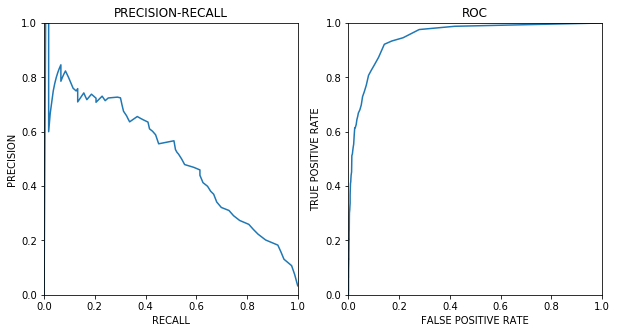

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(recall, precision)
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
plt.title('PRECISION-RECALL')
plt.xlim([0,1])
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(fp_rate, tp_rate)
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Primera parte b

Hacemos funciones para lograr determinar cuales serán los mejores predictores.

## Solución propuesta

In [7]:
def summary_fit(X, Y, f_method, plot=True):
    # Split in train and test
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.4)

    #  Fit with train
    f_method.fit(X_train, Y_train)

    # Predict with test
    predict = f_method.predict(X_test)

    # This is the probability for the '+' class
    proba_yes = f_method.predict_proba(X_test)[:,1]

    # loop over n_p different values for the threshold probabiity
    n_p = 100
    error_rate = np.zeros(n_p)
    precision = np.zeros(n_p)
    recall = np.zeros(n_p)
    tp_rate = np.zeros(n_p)
    fp_rate = np.zeros(n_p)
    threshold = np.linspace(0,0.99, n_p)

    for i in range(n_p):
        ii = proba_yes>threshold[i]
        predict[ii] = 'Yes'
        predict[~ii] = 'No'
        true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
        false_positive = (Y_test == 'No') & (predict == 'Yes')
        false_negative = (Y_test == 'Yes') & (predict == 'No')
        true_negative = (Y_test == 'No') & (predict == 'No')
        n_tp = np.count_nonzero(true_positive)
        n_fp= np.count_nonzero(false_positive)
        n_fn = np.count_nonzero(false_negative)
        n_tn = np.count_nonzero(true_negative)
        if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
        if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
        if((n_fp+n_tn)>0): fp_rate[i] = n_fp/(n_fp+n_tn)

    # compute the area under each curve
    ii = np.argsort(recall)
    pr_area = scipy.integrate.trapz(precision[ii], recall[ii])
    
    ii = np.argsort(fp_rate)
    roc_area = scipy.integrate.trapz(tp_rate[ii], fp_rate[ii])
            
    # compute F1
    F1 = np.max(2.0*precision*recall/(precision+recall+1E-12))
    if plot:
        l = 'Predictors:'
        for k in X.keys(): 
            l=l+' '+k
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(recall, precision)
        plt.xlabel('RECALL')
        plt.ylabel('PRECISION')
        plt.title('PRECISION-RECALL, AREA={:.2f}'.format(pr_area))
        plt.xlim([0,1])
        plt.ylim([0,1])

        plt.subplot(1,2,2)
        plt.plot(fp_rate, tp_rate, label=l)
        plt.xlabel('FALSE POSITIVE RATE')
        plt.ylabel('TRUE POSITIVE RATE')
        plt.title('ROC, AREA={:.2f}'.format(roc_area))
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.legend()
    return {'pr_area':pr_area, 'roc_area':roc_area, 'F1':F1}

In [8]:
def find_best_predictors(X, Y, all_predictors, f_method):
    best = {'pr_area':0.0, 'roc_area':0.0, 'F1':0.0, 'predictors':''}

    # loop over all possible number of predictors
    for n_predictors in range(1,len(all_predictors)+1):
    
        # get all combinations of predictors of lenght=n_predictors
        combinations = itertools.combinations(all_predictors, n_predictors)
        for c in combinations:
            predictors = list(c)
            X_in = X[predictors]

            # if n_predictors=1, try it
            if(n_predictors==1): 
                print('Trying these predictors', predictors)
                areas = summary_fit(X_in, Y, f, plot=False)
            else:
                intersection = list(set(best['predictors']) & set(predictors))
                # only try the new predictors if they include the best['predictors']
                if len(intersection)==len(best['predictors']):
                    print('Trying these predictors', predictors)
                    areas = summary_fit(X_in, Y, f, plot=False)
                    
            # update the best values if needed. The best model increases, the ROC area and the Prec-Recall area and F1.
            if areas['pr_area']>best['pr_area'] and areas['roc_area']>best['roc_area'] and areas['F1'] > best['F1']:
                best['pr_area'] = areas['pr_area']
                best['roc_area'] = areas['roc_area']
                best['F1'] = areas['F1']
                best['predictors'] = predictors
                print('\t\t UPDATED BEST RESULTS: {}'.format(best))
    return best

In [9]:
# Read the data and initialize the binary data to predict
data = pd.read_csv('Boston.csv')

crimebinary = np.repeat('Yes', len(data))
ii = np.array(data['crim']>np.median(data['crim']))
crimebinary[ii] = 'Yes'
crimebinary[~ii] = 'No'
data['CRIME_BINARY'] = crimebinary

# select the full set of predictors to be used
all_predictors = ['zn','indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']

# define X and Y
X = data[all_predictors]
Y = data['CRIME_BINARY']

In [10]:
# Find the best for Logistic Regression
f = sklearn.linear_model.LogisticRegression(solver='lbfgs')
best = find_best_predictors(X, Y, all_predictors, f)
print(' ')
print('The best {}'.format(best))
print(' ')

Trying these predictors ['zn']
		 UPDATED BEST RESULTS: {'pr_area': 0.3339219901719902, 'roc_area': 0.7564102564102564, 'F1': 0.7935222672059974, 'predictors': ['zn']}
Trying these predictors ['indus']
		 UPDATED BEST RESULTS: {'pr_area': 0.7611168619732483, 'roc_area': 0.8452797202797202, 'F1': 0.8016528925614933, 'predictors': ['indus']}
Trying these predictors ['chas']
Trying these predictors ['nox']
		 UPDATED BEST RESULTS: {'pr_area': 0.9196918579190627, 'roc_area': 0.9222481071636575, 'F1': 0.8584905660372366, 'predictors': ['nox']}
Trying these predictors ['rm']
Trying these predictors ['age']
Trying these predictors ['dis']
Trying these predictors ['rad']
Trying these predictors ['tax']
Trying these predictors ['ptratio']
Trying these predictors ['black']
Trying these predictors ['lstat']
Trying these predictors ['medv']
Trying these predictors ['zn', 'nox']
Trying these predictors ['indus', 'nox']
Trying these predictors ['chas', 'nox']
		 UPDATED BEST RESULTS: {'pr_area': 0.9

/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'chas', 'nox', 'rm', 'lstat']
Trying these predictors ['zn', 'chas', 'nox', 'rm', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'dis']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'rad']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'tax']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'ptratio']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'black']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'lstat']
Trying these predictors ['zn', 'chas', 'nox', 'age', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'dis', 'rad']
Trying these predictors ['zn', 'chas', 'nox', 'dis', 'tax']
Trying these predictors ['zn', 'chas', 'nox', 'dis', 'ptratio']
Trying these predictors ['zn', 'chas', 'nox', 'dis', 'black']
Trying these predictors ['zn', 'chas', 'nox', 'dis', 'lstat']
Trying these predictors ['zn', 'chas', 'nox', 'dis', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'rad', 'tax']
Trying these predicto

/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'chas', 'nox', 'rad', 'lstat']
Trying these predictors ['zn', 'chas', 'nox', 'rad', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'tax', 'ptratio']
Trying these predictors ['zn', 'chas', 'nox', 'tax', 'black']
Trying these predictors ['zn', 'chas', 'nox', 'tax', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'chas', 'nox', 'tax', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'chas', 'nox', 'ptratio', 'lstat']
Trying these predictors ['zn', 'chas', 'nox', 'ptratio', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'black', 'lstat']
Trying these predictors ['zn', 'chas', 'nox', 'black', 'medv']
Trying these predictors ['zn', 'chas', 'nox', 'lstat', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'age']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'dis']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'rad']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'tax']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'ptratio']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'rm', 'lstat']
Trying these predictors ['indus', 'chas', 'nox', 'rm', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'age', 'dis']
Trying these predictors ['indus', 'chas', 'nox', 'age', 'rad']
Trying these predictors ['indus', 'chas', 'nox', 'age', 'tax']
Trying these predictors ['indus', 'chas', 'nox', 'age', 'ptratio']
Trying these predictors ['indus', 'chas', 'nox', 'age', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'age', 'lstat']
Trying these predictors ['indus', 'chas', 'nox', 'age', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'dis', 'rad']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'dis', 'tax']
Trying these predictors ['indus', 'chas', 'nox', 'dis', 'ptratio']
Trying these predictors ['indus', 'chas', 'nox', 'dis', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'dis', 'lstat']
Trying these predictors ['indus', 'chas', 'nox', 'dis', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'rad', 'tax']
Trying these predictors ['indus', 'chas', 'nox', 'rad', 'ptratio']
Trying these predictors ['indus', 'chas', 'nox', 'rad', 'black']
Trying these predictors ['indus', 'chas', 'nox', 'rad', 'lstat']
Trying these predictors ['indus', 'chas', 'nox', 'rad', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'tax', 'ptratio']
Trying these predictors ['indus', 'chas', 'nox', 'tax', 'black']
Trying these predictors ['indus', 'chas', 'nox', 'tax', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'tax', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['indus', 'chas', 'nox', 'ptratio', 'lstat']
Trying these predictors ['indus', 'chas', 'nox', 'ptratio', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'black', 'lstat']
Trying these predictors ['indus', 'chas', 'nox', 'black', 'medv']
Trying these predictors ['indus', 'chas', 'nox', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'dis']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'rad']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'tax']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'ptratio']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'black']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'lstat']
Trying these predictors ['chas', 'nox', 'rm', 'age', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'dis', 'rad']
Trying these predictors ['chas', 'nox', 'rm', 'dis', 'tax']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'rm', 'dis', 'ptratio']
Trying these predictors ['chas', 'nox', 'rm', 'dis', 'black']
Trying these predictors ['chas', 'nox', 'rm', 'dis', 'lstat']
Trying these predictors ['chas', 'nox', 'rm', 'dis', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'rad', 'tax']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'rm', 'rad', 'ptratio']
Trying these predictors ['chas', 'nox', 'rm', 'rad', 'black']
Trying these predictors ['chas', 'nox', 'rm', 'rad', 'lstat']
Trying these predictors ['chas', 'nox', 'rm', 'rad', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'rm', 'tax', 'black']
Trying these predictors ['chas', 'nox', 'rm', 'tax', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'rm', 'tax', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'ptratio', 'black']
Trying these predictors ['chas', 'nox', 'rm', 'ptratio', 'lstat']
Trying these predictors ['chas', 'nox', 'rm', 'ptratio', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'black', 'lstat']
Trying these predictors ['chas', 'nox', 'rm', 'black', 'medv']
Trying these predictors ['chas', 'nox', 'rm', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'age', 'dis', 'rad']
Trying these predictors ['chas', 'nox', 'age', 'dis', 'tax']
Trying these predictors ['chas', 'nox', 'age', 'dis', 'ptratio']
Trying these predictors ['chas', 'nox', 'age', 'dis', 'black']
Trying these predictors ['chas', 'nox', 'age', 'dis', 'lstat']
Trying these predictors ['chas', 'nox', 'age', 'dis', 'medv']
Trying these predictors ['chas', 'nox', 'age', 'rad', 'tax']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'age', 'rad', 'ptratio']
Trying these predictors ['chas', 'nox', 'age', 'rad', 'black']
Trying these predictors ['chas', 'nox', 'age', 'rad', 'lstat']
Trying these predictors ['chas', 'nox', 'age', 'rad', 'medv']
Trying these predictors ['chas', 'nox', 'age', 'tax', 'ptratio']
Trying these predictors ['chas', 'nox', 'age', 'tax', 'black']
Trying these predictors ['chas', 'nox', 'age', 'tax', 'lstat']
Trying these predictors ['chas', 'nox', 'age', 'tax', 'medv']
Trying these predictors ['chas', 'nox', 'age', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'age', 'ptratio', 'lstat']
Trying these predictors ['chas', 'nox', 'age', 'ptratio', 'medv']
Trying these predictors ['chas', 'nox', 'age', 'black', 'lstat']
Trying these predictors ['chas', 'nox', 'age', 'black', 'medv']
Trying these predictors ['chas', 'nox', 'age', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'dis', 'rad', 'tax']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'dis', 'rad', 'ptratio']
Trying these predictors ['chas', 'nox', 'dis', 'rad', 'black']
Trying these predictors ['chas', 'nox', 'dis', 'rad', 'lstat']
Trying these predictors ['chas', 'nox', 'dis', 'rad', 'medv']
Trying these predictors ['chas', 'nox', 'dis', 'tax', 'ptratio']
Trying these predictors ['chas', 'nox', 'dis', 'tax', 'black']
Trying these predictors ['chas', 'nox', 'dis', 'tax', 'lstat']
Trying these predictors ['chas', 'nox', 'dis', 'tax', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'dis', 'ptratio', 'black']
Trying these predictors ['chas', 'nox', 'dis', 'ptratio', 'lstat']
Trying these predictors ['chas', 'nox', 'dis', 'ptratio', 'medv']
Trying these predictors ['chas', 'nox', 'dis', 'black', 'lstat']
Trying these predictors ['chas', 'nox', 'dis', 'black', 'medv']
Trying these predictors ['chas', 'nox', 'dis', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'rad', 'tax', 'ptratio']
Trying these predictors ['chas', 'nox', 'rad', 'tax', 'black']
Trying these predictors ['chas', 'nox', 'rad', 'tax', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'rad', 'tax', 'medv']
Trying these predictors ['chas', 'nox', 'rad', 'ptratio', 'black']
Trying these predictors ['chas', 'nox', 'rad', 'ptratio', 'lstat']
Trying these predictors ['chas', 'nox', 'rad', 'ptratio', 'medv']
Trying these predictors ['chas', 'nox', 'rad', 'black', 'lstat']
Trying these predictors ['chas', 'nox', 'rad', 'black', 'medv']
Trying these predictors ['chas', 'nox', 'rad', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'tax', 'ptratio', 'black']
Trying these predictors ['chas', 'nox', 'tax', 'ptratio', 'lstat']
Trying these predictors ['chas', 'nox', 'tax', 'ptratio', 'medv']
Trying these predictors ['chas', 'nox', 'tax', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['chas', 'nox', 'tax', 'black', 'medv']
Trying these predictors ['chas', 'nox', 'tax', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'ptratio', 'black', 'lstat']
Trying these predictors ['chas', 'nox', 'ptratio', 'black', 'medv']
Trying these predictors ['chas', 'nox', 'ptratio', 'lstat', 'medv']
Trying these predictors ['chas', 'nox', 'black', 'lstat', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'rad']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'tax']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'rad']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'tax']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'black']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio']
		 UPDATED BEST RESULTS: {'pr_area': 0.9253163363835133, 'roc_area': 0.936747572815534, 'F1': 0.8749999999995032, 'predictors': ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio']}
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'black']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'black', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'black', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'black', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'tax', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'black', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'tax', 'ptratio', 'black', 'lstat', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']
Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Trying these predictors ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']
 
The best {'pr_area': 0.9253163363835133, 'roc_area': 0.936747572815534, 'F1': 0.8749999999995032, 'predictors': ['zn', 'indus', 'chas', 'nox', 'dis', 'ptratio']}
 


/srv/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [11]:
# Find the best with Linear Discriminant Analysis
f = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
best = find_best_predictors(X, Y, all_predictors, f)
print(' ')
print('The best {}'.format(best))
print(' ')

Trying these predictors ['zn']
		 UPDATED BEST RESULTS: {'pr_area': 0.350181681054256, 'roc_area': 0.7356796116504855, 'F1': 0.7791164658629687, 'predictors': ['zn']}
Trying these predictors ['indus']
		 UPDATED BEST RESULTS: {'pr_area': 0.7356590895158505, 'roc_area': 0.8624538924480682, 'F1': 0.8241758241753315, 'predictors': ['indus']}
Trying these predictors ['chas']
Trying these predictors ['nox']
		 UPDATED BEST RESULTS: {'pr_area': 0.7897162843976058, 'roc_area': 0.9255339805825243, 'F1': 0.8557692307687307, 'predictors': ['nox']}
Trying these predictors ['rm']
Trying these predictors ['age']
Trying these predictors ['dis']
Trying these predictors ['rad']
Trying these predictors ['tax']
Trying these predictors ['ptratio']
Trying these predictors ['black']
Trying these predictors ['lstat']
Trying these predictors ['medv']
Trying these predictors ['zn', 'nox']
		 UPDATED BEST RESULTS: {'pr_area': 0.7999494737260394, 'roc_area': 0.9428069490532892, 'F1': 0.8807339449536284, 'predic

Despues de 5 intentos con logistic regression tengo 5 resultados diferentes

The best {'pr_area': 0.95927442200708224, 'roc_area': 0.95343137254901966, 'F1': 0.90607734806580087, 
'predictors': ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio']}


The best {'pr_area': 0.93341850837668949, 'roc_area': 0.95667550839964632, 'F1': 0.90647482014338687, 
'predictors': ['zn', 'chas', 'nox', 'tax', 'medv']}


The best {'pr_area': 0.91882803724052686, 'roc_area': 0.93843537414965983, 'F1': 0.88235294117597096, 
'predictors': ['zn', 'nox', 'ptratio', 'black']}


The best {'pr_area': 0.94901269335444871, 'roc_area': 0.95237864077669909, 'F1': 0.87850467289669842, 
'predictors': ['zn', 'chas', 'nox', 'age', 'dis', 'tax', 'lstat']}


The best {'pr_area': 0.95658316625643014, 'roc_area': 0.9477582846003898, 'F1': 0.89497716894927182, 
'predictors': ['chas', 'nox', 'age', 'tax', 'lstat']}

El único predictor que se encuentran en todos los 5 intentos es nox, se encuentran 4 veces chas, tax, zn


Despues de 5 intentos con Linear Discriminant Analysis tengo 5 resultados diferentes

The best {'pr_area': 0.93705403867125503, 'roc_area': 0.95151426907396619, 'F1': 0.89592760180945774, 
          'predictors': ['indus', 'nox', 'dis']}
          
          
The best {'pr_area': 0.85648960827681753, 'roc_area': 0.95633145302470335, 'F1': 0.8927038626604481, 
    'predictors': ['chas', 'nox', 'age', 'dis', 'tax', 'lstat']}
    
    
The best {'pr_area': 0.92179711248156537, 'roc_area': 0.96482021379980565, 'F1': 0.90350877192932766, 
'predictors': ['zn', 'indus', 'chas', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']}


The best {'pr_area': 0.84667733614022478, 'roc_area': 0.95971655989128324, 'F1': 0.91866028708083991, 
'predictors': ['zn', 'nox']}


The best {'pr_area': 0.88329262131391273, 'roc_area': 0.96158334954289049, 'F1': 0.89177489177439506, 
'predictors': ['nox', 'dis']}

Ningún predictor se encuentra en todos los 5 intentos. nox y dis se encuentran 4 veces.

# Cambios efectuados a la función anterior

Acá se hace una pequeña variación con un programa que lea todos los outputs y luego determine con cierta presición que variables serán las más adecuadas

In [20]:
def summary_fit(X, Y, f_method, plot=True):
    # Split in train and test
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.4)

    #  Fit with train
    f_method.fit(X_train, Y_train)

    # Predict with test
    predict = f_method.predict(X_test)

    # This is the probability for the '+' class
    proba_yes = f_method.predict_proba(X_test)[:,1]

    # loop over n_p different values for the threshold probabiity
    n_p = 100
    error_rate = np.zeros(n_p)
    precision = np.zeros(n_p)
    recall = np.zeros(n_p)
    tp_rate = np.zeros(n_p)
    fp_rate = np.zeros(n_p)
    threshold = np.linspace(0,0.99, n_p)

    for i in range(n_p):
        ii = proba_yes>threshold[i]
        predict[ii] = 'Yes'
        predict[~ii] = 'No'
        true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
        false_positive = (Y_test == 'No') & (predict == 'Yes')
        false_negative = (Y_test == 'Yes') & (predict == 'No')
        true_negative = (Y_test == 'No') & (predict == 'No')
        n_tp = np.count_nonzero(true_positive)
        n_fp= np.count_nonzero(false_positive)
        n_fn = np.count_nonzero(false_negative)
        n_tn = np.count_nonzero(true_negative)
        if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
        if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
        if((n_fp+n_tn)>0): fp_rate[i] = n_fp/(n_fp+n_tn)

    # compute the area under each curve
    ii = np.argsort(recall)
    pr_area = scipy.integrate.trapz(precision[ii], recall[ii])
    
    ii = np.argsort(fp_rate)
    roc_area = scipy.integrate.trapz(tp_rate[ii], fp_rate[ii])
            
    # compute F1
    F1 = np.max(2.0*precision*recall/(precision+recall+1E-12))
    if plot:
        l = 'Predictors:'
        for k in X.keys(): 
            l=l+' '+k
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(recall, precision)
        plt.xlabel('RECALL')
        plt.ylabel('PRECISION')
        plt.title('PRECISION-RECALL, AREA={:.2f}'.format(pr_area))
        plt.xlim([0,1])
        plt.ylim([0,1])

        plt.subplot(1,2,2)
        plt.plot(fp_rate, tp_rate, label=l)
        plt.xlabel('FALSE POSITIVE RATE')
        plt.ylabel('TRUE POSITIVE RATE')
        plt.title('ROC, AREA={:.2f}'.format(roc_area))
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.legend()
        plt.show()
    return {'pr_area':pr_area, 'roc_area':roc_area, 'F1':F1}

In [21]:
def find_best_predictors(X, Y, all_predictors, f_method):
    best = {'pr_area':0.0, 'roc_area':0.0, 'F1':0.0, 'predictors':''}

    # loop over all possible number of predictors
    for n_predictors in range(1,len(all_predictors)+1):
    
        # get all combinations of predictors of lenght=n_predictors
        combinations = itertools.combinations(all_predictors, n_predictors)
        for c in combinations:
            predictors = list(c)
            X_in = X[predictors]
            
            # if n_predictors=1, try it
            if(n_predictors==1): 
                # print('Trying these predictors', predictors) #We comment this printing
                areas = summary_fit(X_in, Y, f, plot=False)
            else:
                intersection = list(set(best['predictors']) & set(predictors))
                # only try the new predictors if they include the best['predictors']
                if len(intersection)==len(best['predictors']):
                    # print('Trying these predictors', predictors) #We comment this printing
                    areas = summary_fit(X_in, Y, f, plot=False)
                    
            # update the best values if needed. The best model increases, the ROC area and the Prec-Recall area and F1.
            if areas['pr_area']>best['pr_area'] and areas['roc_area']>best['roc_area'] and areas['F1'] > best['F1']:
                best['pr_area'] = areas['pr_area']
                best['roc_area'] = areas['roc_area']
                best['F1'] = areas['F1']
                best['predictors'] = predictors
                # print('\t\t UPDATED BEST RESULTS: {}'.format(best)) #We comment this printing
    return best

In [22]:
data = pd.read_csv("Auto.csv")
Mpgbinary = np.repeat('Yes', len(data))

In [23]:
ii = np.array(data['mpg']>np.median(data['mpg']))
Mpgbinary[~ii] = 'No'
data["MPG_Binary"] = Mpgbinary
# print(Mpgbinary)
all_predictors=["cylinders","displacement","horsepower","acceleration","year"]
X = data[all_predictors]
Y = data['MPG_Binary']
metodos=["Logistic","Discriminant"]

In [24]:
for metodo in metodos:
    N=100
    if metodo == "Logistic":
        # Find the best for Logistic Regression
        f = sklearn.linear_model.LogisticRegression(solver='lbfgs')
        # best = find_best_predictors(X, Y, all_predictors, f)
        # print(best["predictors"])
        archivo = open("Logistic_regression.txt","w")
        for i in range(N):
            best = find_best_predictors(X, Y, all_predictors, f)
            archivo.write(str(best["predictors"])+"\n")
            print((i+1)/N)
        archivo.close()
        print("Done " + metodo)
    else:
        # Find the best with Linear Discriminant Analysis
        f = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
        archivo = open("Linear_Discriminant.txt","w")
        for i in range(N):
            best = find_best_predictors(X, Y, all_predictors, f)
            archivo.write(str(best["predictors"])+"\n")
            print((i+1)/N)
        archivo.close()
        print("Done " + metodo)

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
Done Logistic
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
Done D

In [25]:
def Analisis_of_data(archivo,tolerance):
    a= open(archivo,"r")
    lines= a.readlines()
    total=[]
    for i in lines:
        i=i[1:-2]
        l = i.split(",")
        total += l
    variables={}
    for i in total:
        if i in variables:
            continue
        else:
            variables[i]=total.count(i) 
    decide = []
    for i in variables.keys():
        if variables[i] < tolerance*len(lines):
            continue
        else:
            decide.append(i)
    print("the revelant variables are: ",decide)
prec=0.5
Analisis_of_data("Logistic_regression.txt",prec)
Analisis_of_data("Linear_Discriminant.txt",prec)

the revelant variables are:  ["'cylinders'"]
the revelant variables are:  ["'cylinders'", " 'displacement'"]
